In [1]:
import itertools
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [2]:
"""Overall initialization"""

# Overall initialization
seed = 41
torch.manual_seed(seed)

# Data types
dtype = torch.FloatTensor
np_dtype = np.float32

# Model parameters
latent_size = 100

# Training parameters
batch_size = 128
gen_learning_rate = 2 * 1e-4
dis_learning_rate = gen_learning_rate

# Data parameters
cifar_dataset_path = 'cifar_dataset'

In [4]:
"""Datasets"""

torch.manual_seed(seed)
rng = np.random.RandomState(seed)
rng2 = np.random.RandomState(seed + 1)


def sample_latent_space(n):
    return rng2.randn(n, latent_size)


def sample_latent_space_torch(n):
    return torch.randn(n, latent_size, dtype=torch.float32)

num_data_workers = 4
desired_image_size = (64, 64)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(desired_image_size),
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root=cifar_dataset_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_data_workers)

testset = torchvision.datasets.CIFAR10(root=cifar_dataset_path, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_data_workers)

# class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Nuber of train samples: {}".format(len(trainset)))
print("Nuber of test samples: {}".format(len(testset)))
# print("Nuber of classes: {}".format(len(class_names)))

Files already downloaded and verified
Files already downloaded and verified
Nuber of train samples: 50000
Nuber of test samples: 10000


In [29]:
"""Network models for generator and discriminator"""

class Generator(nn.Module):

    def __init__(self, latent_size, output_size, hidden_units_list):
        super(Generator, self).__init__()

        self.latent_size = latent_size

        # Generator layers
        layers = []
        prev_layer_size = latent_size
        for i, num_hidden_units in enumerate(hidden_units_list):
            layers.append(nn.Linear(prev_layer_size, num_hidden_units))
            if i > 0:
                layers.append(nn.BatchNorm1d(num_hidden_units))
            layers.append(nn.ReLU())
            prev_layer_size = num_hidden_units
        self.gen_fc_list = nn.Sequential(*layers)

        self.output_layer = nn.Linear(prev_layer_size, output_size)

    def forward(self, z):
        x = self.gen_fc_list(z)
        x = F.tanh(self.output_layer(x))
        return x


class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_units_list):
        super(Discriminator, self).__init__()

        self.input_size = input_size

        # Discriminator layers
        layers = []
        prev_layer_size = input_size
        for i, num_hidden_units in enumerate(hidden_units_list):
            layers.append(nn.Linear(prev_layer_size, num_hidden_units))
            if i > 0:
                layers.append(nn.BatchNorm1d(num_hidden_units))
            layers.append(nn.LeakyReLU())
            prev_layer_size = num_hidden_units
        self.dis_fc_list = nn.Sequential(*layers)

        self.output_layer = nn.Linear(prev_layer_size, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.dis_fc_list(x)
        y = F.sigmoid(self.output_layer(y))
        return y


class DCGenerator(nn.Module):

    def __init__(self, latent_size, nc=1):
        super(DCGenerator, self).__init__()

        self.latent_size = latent_size

        ngf = 128
        bias = True

        self.layers = nn.Sequential(
            # state size: latent_size x 1 x 1
            nn.ConvTranspose2d(self.latent_size, 8 * ngf, 4, 1, 0, bias=bias),
            nn.BatchNorm2d(8 * ngf),
            nn.ReLU(inplace=True),
            # state size: (8 * ngf) x 4 x 4
            nn.ConvTranspose2d(8 * ngf, 4 * ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(4 * ngf),
            nn.ReLU(inplace=True),
            # state size: (4 * ndf) x 8 x 8
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(2 * ngf),
            nn.ReLU(inplace=True),
            # state size: (2 * ngf) x 16 x 16
            nn.ConvTranspose2d(2 * ngf, ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=bias),
            # state size: nc x 64 x 64
            nn.Tanh()
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, 0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, z):
        assert z.size(1) == self.latent_size
        z = z.view(-1, self.latent_size, 1, 1)
        x = self.layers(z)
        return x


class DCDiscriminator(nn.Module):

    def __init__(self, nc=1):
        super(DCDiscriminator, self).__init__()

        ndf = 128
        neg_slope = 0.2
        bias = True

        self.layers = nn.Sequential(
            # state size: nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=bias),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: nc x 32 x 32
            nn.Conv2d(ndf, 2 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: ndf x 16 x 16
            nn.Conv2d(2 * ndf, 4 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(4 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: (4 * ndf) x 8 x 8
            nn.Conv2d(4 * ndf, 8 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(8 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: (8 * ndf) x 4 x 4
            nn.Conv2d(8 * ndf, 1, 4, 1, 0, bias=bias),
            # state size: 1 x 1 x 1
            nn.Sigmoid()
            # state size: 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.normal_(m.weight, 0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.layers(x)
        y = y.view(-1, 1)
        return y


class GAN(nn.Module):

    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()

        self.generator = generator
        self.discriminator = discriminator

    def loss_discriminator(self, z, x_real):
        x_fake = self.generator(z)
        y_fake = self.discriminator(x_fake)
        y_real = self.discriminator(x_real)
        return -torch.mean(torch.log(y_real)) - torch.mean(torch.log(1 - y_fake))

    def loss_generator(self, z):
        x = self.generator(z)
        y_fake = self.discriminator(x)
        return -torch.mean(torch.log(y_fake))


nc = 3
# # gen_ = Generator(latent_size, image_size_flat, gen_hidden_units_list)
# # dis_ = Discriminator(image_size_flat, dis_hidden_units_list)
gen_ = DCGenerator(latent_size, nc)
dis_ = DCDiscriminator(nc)
model = GAN(gen_, dis_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GAN(
  (generator): DCGenerator(
    (layers): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (13): Tanh()
    )
  )
  (discriminator

In [33]:
"""Training"""

# criterion = nn.BCELoss()

# Optimizer
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=gen_learning_rate, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=dis_learning_rate, betas=(0.5, 0.999))

model.train()

discriminator_train_steps = 1

num_epochs = 100000
for epoch in range(num_epochs):
    data_iter = iter(train_loader)
    train_loss_dis = 0
    train_loss_gen = 0

    for i, (x, _) in enumerate(train_loader):

        zeros = torch.zeros(x.size(0), 1, dtype=torch.float32).to(device)
        ones = torch.ones(x.size(0), 1, dtype=torch.float32).to(device)

        x = x.to(device)
        z = sample_latent_space(x.size(0))
        z = torch.from_numpy(z).float()
        z = z.to(device)
#                 y_real = model.discriminator(x)
#                 y_fake = model.discriminator(model.generator(z))
#                 print("Discrimantor on real samples: {:.4f}, on fake samples: {:.4f}".format(
#                     torch.mean(y_real), torch.mean(y_fake)))
        loss_dis = model.loss_discriminator(z, x)
#         loss_dis = criterion(model.discriminator(x), ones) + criterion(model.discriminator(model.generator(z)), zeros)
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
        train_loss_dis += loss_dis.data.item() / discriminator_train_steps

        z = sample_latent_space(x.size(0))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        loss_gen = model.loss_generator(z)
#         loss_gen = criterion(model.discriminator(model.generator(z)), ones)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        train_loss_gen += loss_gen.data.item()

#         x = Variable(x.type(dtype))

        if i % 5 == 0:
            print("epoch={}, i={}".format(epoch, i))
            print("  loss_real: {:.4f}, loss_fake: {:.4f}".format(
                train_loss_gen / (i + 1), train_loss_dis / (i + 1)))

    print('====> Train set loss_real: {:.4f}, loss_fake: {:.4f}'.format(
        train_loss_gen / (i + 1), train_loss_dis / (i + 1)))

epoch=0, i=0
  loss_real: 7.7697, loss_fake: 0.2446
epoch=0, i=5
  loss_real: 3.4855, loss_fake: 1.1846
epoch=0, i=10
  loss_real: 3.2562, loss_fake: 1.0522
epoch=0, i=15
  loss_real: 3.2877, loss_fake: 1.0384
epoch=0, i=20
  loss_real: 3.3360, loss_fake: 0.9976
epoch=0, i=25
  loss_real: 3.3846, loss_fake: 1.0290
epoch=0, i=30
  loss_real: 3.3336, loss_fake: 0.9821
epoch=0, i=35
  loss_real: 3.2875, loss_fake: 0.9686
epoch=0, i=40
  loss_real: 3.3325, loss_fake: 0.9360
epoch=0, i=45
  loss_real: 3.3558, loss_fake: 0.8925
epoch=0, i=50
  loss_real: 3.4412, loss_fake: 0.9433
epoch=0, i=55
  loss_real: 3.4512, loss_fake: 0.9769
epoch=0, i=60
  loss_real: 3.4081, loss_fake: 0.9663
epoch=0, i=65
  loss_real: 3.3766, loss_fake: 0.9433
epoch=0, i=70
  loss_real: 3.3748, loss_fake: 0.9209
epoch=0, i=75
  loss_real: 3.3360, loss_fake: 0.9278
epoch=0, i=80
  loss_real: 3.2984, loss_fake: 0.9164
epoch=0, i=85
  loss_real: 3.2995, loss_fake: 0.9154
epoch=0, i=90
  loss_real: 3.3171, loss_fake: 0.

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f44512e2f98>>
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/mult

epoch=1, i=0
  loss_real: 0.8225, loss_fake: 1.2353
epoch=1, i=5
  loss_real: 2.5446, loss_fake: 1.2668
epoch=1, i=10
  loss_real: 2.7051, loss_fake: 1.1209
epoch=1, i=15
  loss_real: 2.6648, loss_fake: 1.0887
epoch=1, i=20
  loss_real: 2.6175, loss_fake: 1.0417
epoch=1, i=25
  loss_real: 2.6278, loss_fake: 0.9804
epoch=1, i=30
  loss_real: 2.5519, loss_fake: 0.9460
epoch=1, i=35
  loss_real: 2.5598, loss_fake: 0.9293
epoch=1, i=40
  loss_real: 2.4898, loss_fake: 0.9326
epoch=1, i=45
  loss_real: 2.4765, loss_fake: 0.9128
epoch=1, i=50
  loss_real: 2.4513, loss_fake: 0.8889
epoch=1, i=55
  loss_real: 2.4781, loss_fake: 0.9374
epoch=1, i=60
  loss_real: 2.4615, loss_fake: 0.9161
epoch=1, i=65
  loss_real: 2.4551, loss_fake: 0.9047
epoch=1, i=70
  loss_real: 2.4703, loss_fake: 0.8863
epoch=1, i=75
  loss_real: 2.4755, loss_fake: 0.8827
epoch=1, i=80
  loss_real: 2.5045, loss_fake: 0.9302
epoch=1, i=85
  loss_real: 2.4917, loss_fake: 0.9327
epoch=1, i=90
  loss_real: 2.4718, loss_fake: 0.

epoch=2, i=365
  loss_real: 2.2774, loss_fake: 0.8817
epoch=2, i=370
  loss_real: 2.2714, loss_fake: 0.8824
epoch=2, i=375
  loss_real: 2.2679, loss_fake: 0.8837
epoch=2, i=380
  loss_real: 2.2671, loss_fake: 0.8844
epoch=2, i=385
  loss_real: 2.2641, loss_fake: 0.8824
epoch=2, i=390
  loss_real: 2.2584, loss_fake: 0.8800
====> Train set loss_real: 2.2584, loss_fake: 0.8800


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4451265f28>>
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/mult

epoch=3, i=0
  loss_real: 4.0779, loss_fake: 0.9791
epoch=3, i=5
  loss_real: 2.6212, loss_fake: 1.2369
epoch=3, i=10
  loss_real: 2.3779, loss_fake: 1.0268
epoch=3, i=15
  loss_real: 2.3007, loss_fake: 0.9920
epoch=3, i=20
  loss_real: 2.2801, loss_fake: 0.9349
epoch=3, i=25
  loss_real: 2.2735, loss_fake: 0.8918
epoch=3, i=30
  loss_real: 2.2273, loss_fake: 0.8861
epoch=3, i=35
  loss_real: 2.2147, loss_fake: 0.8611
epoch=3, i=40
  loss_real: 2.2262, loss_fake: 0.8399
epoch=3, i=45
  loss_real: 2.2491, loss_fake: 0.9317
epoch=3, i=50
  loss_real: 2.2299, loss_fake: 0.9238
epoch=3, i=55
  loss_real: 2.2329, loss_fake: 0.9233
epoch=3, i=60
  loss_real: 2.2102, loss_fake: 0.9353
epoch=3, i=65
  loss_real: 2.1926, loss_fake: 0.9232
epoch=3, i=70
  loss_real: 2.1942, loss_fake: 0.9122
epoch=3, i=75
  loss_real: 2.1942, loss_fake: 0.9207
epoch=3, i=80
  loss_real: 2.1725, loss_fake: 0.9094
epoch=3, i=85
  loss_real: 2.1837, loss_fake: 0.9028
epoch=3, i=90
  loss_real: 2.1748, loss_fake: 0.

epoch=4, i=365
  loss_real: 2.2269, loss_fake: 0.8940
epoch=4, i=370
  loss_real: 2.2297, loss_fake: 0.8889
epoch=4, i=375
  loss_real: 2.2381, loss_fake: 0.8861
epoch=4, i=380
  loss_real: 2.2372, loss_fake: 0.8936
epoch=4, i=385
  loss_real: 2.2337, loss_fake: 0.8931
epoch=4, i=390
  loss_real: 2.2298, loss_fake: 0.8901
====> Train set loss_real: 2.2298, loss_fake: 0.8901
epoch=5, i=0
  loss_real: 4.0470, loss_fake: 1.0137
epoch=5, i=5
  loss_real: 2.7077, loss_fake: 0.6664
epoch=5, i=10
  loss_real: 2.7233, loss_fake: 0.5527
epoch=5, i=15
  loss_real: 2.7452, loss_fake: 0.4583
epoch=5, i=20
  loss_real: 2.8023, loss_fake: 0.4796
epoch=5, i=25
  loss_real: 2.7461, loss_fake: 0.6968
epoch=5, i=30
  loss_real: 2.6207, loss_fake: 0.6991
epoch=5, i=35
  loss_real: 2.5447, loss_fake: 0.6980
epoch=5, i=40
  loss_real: 2.5292, loss_fake: 0.6983
epoch=5, i=45
  loss_real: 2.5347, loss_fake: 0.7980
epoch=5, i=50
  loss_real: 2.4698, loss_fake: 0.8076
epoch=5, i=55
  loss_real: 2.4353, loss_fa

epoch=6, i=330
  loss_real: 2.5179, loss_fake: 0.7627
epoch=6, i=335
  loss_real: 2.5115, loss_fake: 0.7605
epoch=6, i=340
  loss_real: 2.5183, loss_fake: 0.7545
epoch=6, i=345
  loss_real: 2.5291, loss_fake: 0.7622
epoch=6, i=350
  loss_real: 2.5245, loss_fake: 0.7619
epoch=6, i=355
  loss_real: 2.5232, loss_fake: 0.7600
epoch=6, i=360
  loss_real: 2.5338, loss_fake: 0.7562
epoch=6, i=365
  loss_real: 2.5335, loss_fake: 0.7658
epoch=6, i=370
  loss_real: 2.5273, loss_fake: 0.7673
epoch=6, i=375
  loss_real: 2.5187, loss_fake: 0.7691
epoch=6, i=380
  loss_real: 2.5182, loss_fake: 0.7725
epoch=6, i=385
  loss_real: 2.5116, loss_fake: 0.7711
epoch=6, i=390
  loss_real: 2.5204, loss_fake: 0.7652
====> Train set loss_real: 2.5204, loss_fake: 0.7652


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4451265f28>>
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/reduction

epoch=7, i=0
  loss_real: 3.9742, loss_fake: 0.1538
epoch=7, i=5
  loss_real: 3.5655, loss_fake: 0.2303
epoch=7, i=10
  loss_real: 3.1970, loss_fake: 1.1806
epoch=7, i=15
  loss_real: 2.7150, loss_fake: 1.0676
epoch=7, i=20
  loss_real: 2.5147, loss_fake: 0.9876
epoch=7, i=25
  loss_real: 2.4595, loss_fake: 0.9302
epoch=7, i=30
  loss_real: 2.4999, loss_fake: 0.8500
epoch=7, i=35
  loss_real: 2.5610, loss_fake: 0.7907
epoch=7, i=40
  loss_real: 2.5611, loss_fake: 0.8673
epoch=7, i=45
  loss_real: 2.4920, loss_fake: 0.8503
epoch=7, i=50
  loss_real: 2.4908, loss_fake: 0.8352
epoch=7, i=55
  loss_real: 2.5081, loss_fake: 0.8668
epoch=7, i=60
  loss_real: 2.5066, loss_fake: 0.8320
epoch=7, i=65
  loss_real: 2.5501, loss_fake: 0.8088
epoch=7, i=70
  loss_real: 2.5290, loss_fake: 0.8424
epoch=7, i=75
  loss_real: 2.4956, loss_fake: 0.8383
epoch=7, i=80
  loss_real: 2.4930, loss_fake: 0.8135
epoch=7, i=85
  loss_real: 2.5325, loss_fake: 0.7815
epoch=7, i=90
  loss_real: 2.5953, loss_fake: 0.

Process Process-164:
Process Process-161:
Process Process-162:
Process Process-167:
Process Process-168:
Process Process-163:
Process Process-166:
Process Process-165:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/proc

  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
KeyboardInterrupt
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/bhepp/anaconda3/envs/ml/lib/python3.

KeyboardInterrupt: 

Discriminator on fake samples: tensor(0.4671, device='cuda:0')


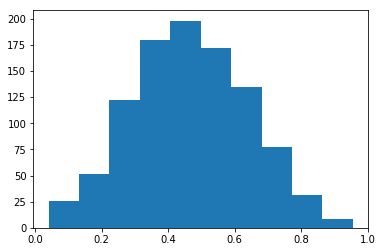

Discriminator on real samples: tensor(0.6606, device='cuda:0')
tensor(0.6606, device='cuda:0')


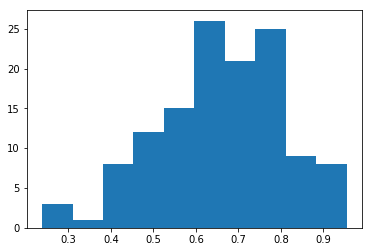

In [34]:
"""Compare discriminator on real and fake samples"""

num_samples_to_generate = 1000

model.eval()

with torch.no_grad():
    # seed = 42
    # rng = np.random.RandomState(seed)
    # Sample latent vectors
    z = sample_latent_space(num_samples_to_generate)
    z = torch.from_numpy(z).float()
    z = z.to(device)
    x = model.generator(z)
    y = model.discriminator(x)
    print("Discriminator on fake samples:", torch.mean(y))
    plt.hist(y.data.cpu().numpy())
    plt.show()

    x = next(iter(train_loader))[0]
    x = x.to(device)
    y = model.discriminator(x)
    print("Discriminator on real samples:", torch.mean(y))
    print(torch.mean(y))
    plt.hist(y.data.cpu().numpy())
    plt.show()


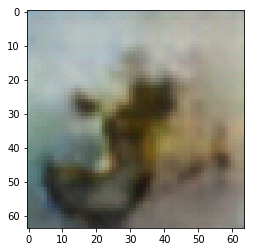

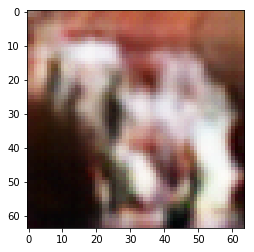

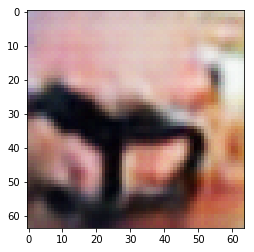

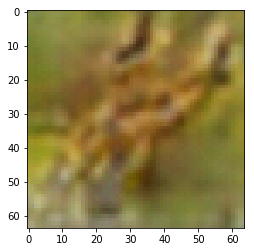

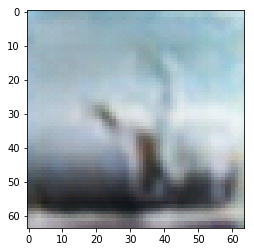

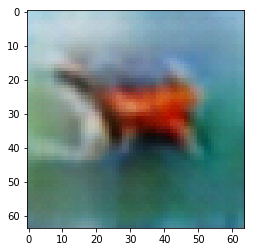

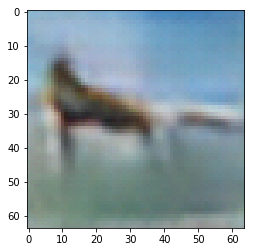

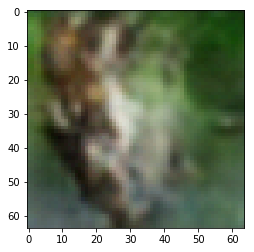

In [42]:
"""Sample some images"""

model.eval()

with torch.no_grad():
    num_samples_to_generate = 8
    z = sample_latent_space(num_samples_to_generate)
    z = torch.from_numpy(z).float()
    z = z.to(device)
    samples = model.generator(z)
    samples = samples.cpu()

for i in range(samples.size(0)):
    sample = samples[i, ...]
    sample = sample.permute(1, 2, 0)
    sample = sample.data.numpy()
    sample = np.clip(sample, 0, 1)
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.show()

0.89411765 0.03529412
(64, 64, 3) 0.03529412 0.89411765


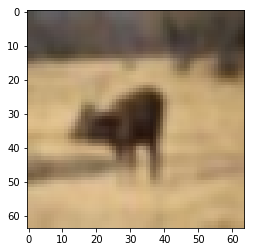

1.0 0.003921569
(64, 64, 3) 0.003921569 1.0


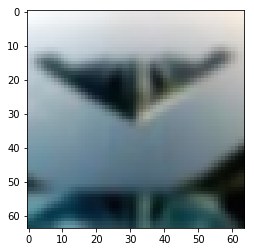

1.0 0.015686275
(64, 64, 3) 0.015686275 1.0


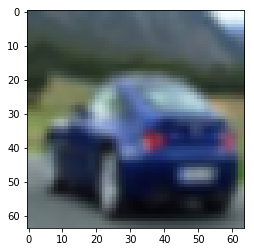

0.69411767 0.023529412
(64, 64, 3) 0.023529412 0.69411767


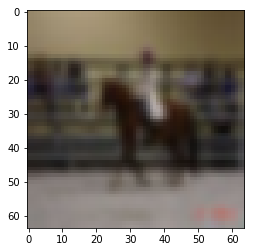

0.84705883 0.023529412
(64, 64, 3) 0.023529412 0.84705883


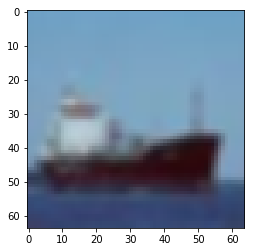

0.8627451 0.12156863
(64, 64, 3) 0.12156863 0.8627451


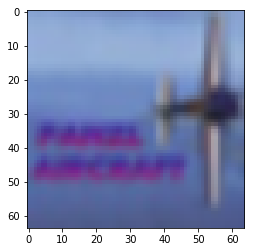

1.0 0.101960786
(64, 64, 3) 0.101960786 1.0


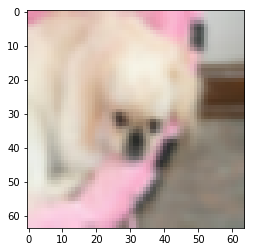

0.92941177 0.003921569
(64, 64, 3) 0.003921569 0.92941177


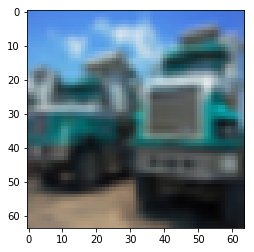

In [20]:
"""Show real images"""

num_images = 8
samples = next(iter(train_loader))[0][:num_images]
for i in range(samples.size(0)):
    sample = samples[i, ...]
    sample = sample.permute(1, 2, 0)
    sample = sample.data.numpy()
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.show()

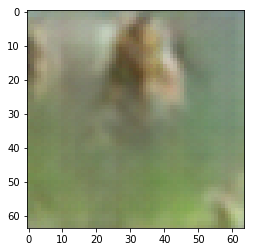

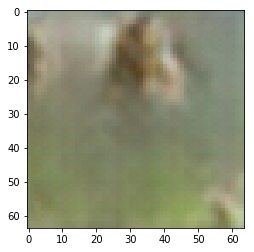

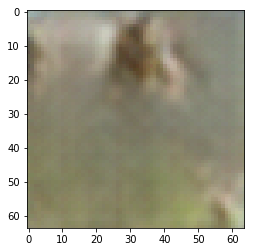

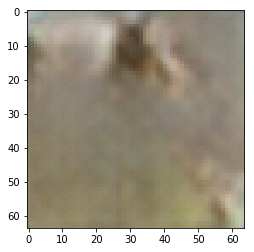

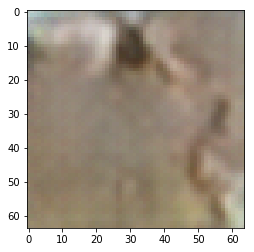

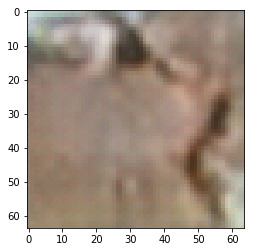

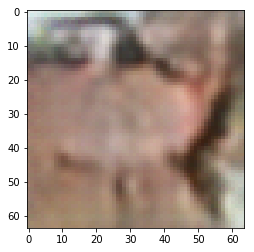

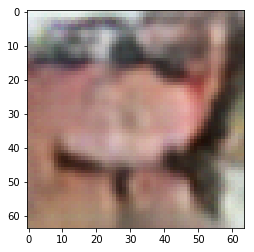

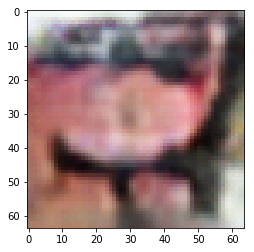

In [41]:
"""Interpolate between images"""

model.eval()

# seed = 46
# rng = np.random.RandomState(seed)
z = sample_latent_space_torch(2)
w = Variable(torch.linspace(0, 1, 10))
z = z[0, ...] + (z[1, ...] - z[0, ...]) * w[:, None]
z = z.to(device)
x = model.generator(z)

# x = x.data.cpu().numpy().reshape((-1, image_size_y, image_size_x))
x = x.permute(0, 2, 3, 1)
x = x.data.cpu().numpy()
x1 = x[0, ...]
x2 = x[-1, ...]

plt.figure()
plt.imshow(x1, cmap="gray")
plt.close()
for i in range(x.shape[0]):
    plt.figure()
    plt.imshow(x[i, ...], cmap="gray")
plt.close()
plt.figure()
plt.imshow(x2, cmap="gray")
plt.close()
plt.show()
